In [2]:
#Question 2
import numpy as np
import matplotlib.pyplot as plt

def logistic_loss(w, x, y):
    """Scalar logistic loss for 1D features."""
    vals = np.log(1 + np.exp(-y * (w * x)))
    return np.mean(vals)

#given touples 
datasets = {
    "Case A": {
        "x": np.array([-1.0, 0.0, 1.0]),
        "y": np.array([-1.0, 1.0, -1.0])
    },
    "Case B": {
        "x": np.array([-2.0, -1.0, 0.0, 1.0]),
        "y": np.array([-1.0, -1.0, 1.0, 1.0])
    }
}



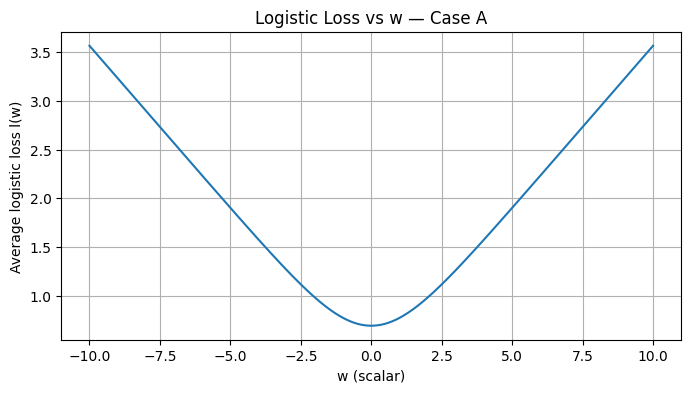

Case A:
  Approx min at w ≈ 0.000
  Min loss ≈ 0.693147
  Loss(w=-10)=3.564413, Loss(w=10)=3.564413
---------------------------------------------------


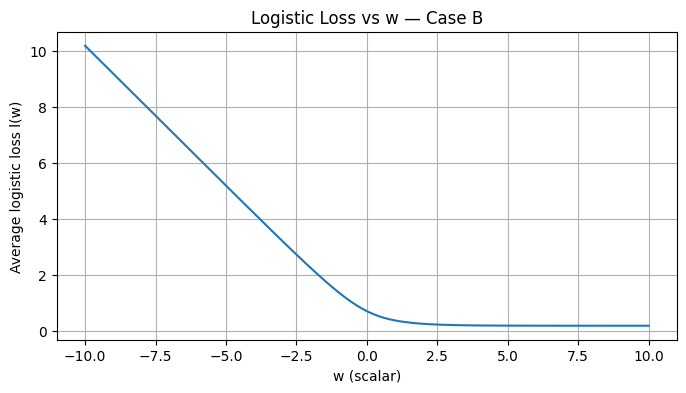

Case B:
  Approx min at w ≈ 10.000
  Min loss ≈ 0.173309
  Loss(w=-10)=10.173309, Loss(w=10)=0.173309
---------------------------------------------------


In [3]:
# w values
w_vals = np.linspace(-10, 10, 2001)

#plots
for name, data in datasets.items():
    losses = np.array([logistic_loss(w, data["x"], data["y"]) for w in w_vals])

    
    plt.figure(figsize=(8, 4))
    plt.plot(w_vals, losses)
    plt.title(f"Logistic Loss vs w — {name}")
    plt.xlabel("w (scalar)")
    plt.ylabel("Average logistic loss l(w)")
    plt.grid(True)
    plt.show()

    
    idx = np.argmin(losses)
    print(f"{name}:")
    print(f"  Approx min at w ≈ {w_vals[idx]:.3f}")
    print(f"  Min loss ≈ {losses[idx]:.6f}")
    print(f"  Loss(w=-10)={losses[0]:.6f}, Loss(w=10)={losses[-1]:.6f}")
    print("---------------------------------------------------")
